## とりあえずデータを見ていくnotebook

【このコンペの目標】
* よくあるBERTくらいを見ないで書けるようになること
    * mecab + bertのcl-tohokuとか --

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import MeCab
import re
import demoji, mojimoji
import neologdn

from config import *

### データ読み込み

In [2]:
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")

df = pd.concat([train, test]).reset_index(drop=True)
df.head(2)

,id,source,text,label
0,80074aa43,news4vip,まともに相手されてない人との関係なんて\nそんな大事にするものか？,0.0
1,6378fea6b,livejupiter,最近はアヘアヘQSマンやない？ ｲｲ!(・∀・)+1-0(・Ａ・)ｲｸﾅｲ!,0.0


In [3]:
(df.shape, train.shape, test.shape)

((8479, 4), (5256, 4), (3223, 3))

### タスク確認
* Stratified KFold

In [4]:
_t = pd.DataFrame(
    train[label_name].value_counts()
)
_t["pct[%]"] = np.round(train[label_name].value_counts()/train.shape[0]*100., 1)
display(_t); del _t

,label,pct[%]
0,4950,94.2
1,306,5.8


* ソースの存在比はtrain-testで大差なし

In [34]:
source_df = pd.DataFrame(train["source"].value_counts()).rename(columns={"source": "train"})
source_df["test"] = test["source"].value_counts()
source_df["train_pct[%]"] = np.round(source_df["train"]/source_df["train"].sum()*100., 1)
source_df["test_pct[%]"] = np.round(source_df["test"]/source_df["test"].sum()*100., 1)
source_df

,train,test,train_pct[%],test_pct[%]
newsplus,1967,1245,37.4,38.6
news4vip,1849,1141,35.2,35.4
livejupiter,1440,837,27.4,26.0


## textを正規化

In [6]:
def clean_text(text: str) -> str:
    """
    日本語から記号とかを削除
    タスク・与えられたデータによって適宜見ながらやるしかなさそう
    絵文字が鬼門という印象あり --

    <参考>
    * https://note.com/narudesu/n/na35de30a583a
    
    """
    # 改行コード削除 --
    text = text.replace("\n", "").replace("\r", "")

    # 半角-全角の正規化 --
    text = neologdn.normalize(text)

    # URL削除 --
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text)
    text = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text)    

    # 絵文字の削除 --
    text = demoji.replace(string=text, repl="")

    # 記号系の削除(半角, 全角) --
    text = re.sub(r'[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]', '', text)
    text = re.sub("[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)

    return text

In [7]:
df["clean_text"] = df["text"].map(lambda x: clean_text(x))

## 8000なら全数調査できそう
(感想)
* demojiは思ったほど絵文字をシバけない
* 

In [44]:
pd.set_option("display.max_rows", 200)
display(df.loc[:, ["source", "label", "clean_text"]])

,source,label,clean_text
0,news4vip,0.0,まともに相手されてない人との関係なんてそんな大事にするものか?
1,livejupiter,0.0,最近はアヘアヘQSマンやない? イイ!(・∀・)+1-0(・A・)イクナイ!
2,livejupiter,1.0,日本人として生まれても無能な低学歴って分かったら日本人の権利剥奪して追放すべきやろ甘えるな
3,livejupiter,0.0,よくよく思えば川上は配布にしたらとんでもなく有能だよなガチャから引いたら圧倒的歓喜レベルやで
4,newsplus,0.0,押井は原作レイプの専門家だから原作マンガの真意を誤解させることに関してはプロだがそれ以外には...
...,...,...,...
8474,news4vip,NaN,1人がいいのか?なんで変なのと同棲したのか…なにがしたいんだ…
8475,newsplus,NaN,ロシアもだなあ元北朝鮮はロシアの工作で作られた国だから
8476,newsplus,NaN,クネが国境に拡声器を設置して昼も夜も北の悪口鳴らしてんだとよお互い当たらないように大砲撃ち合...
8477,news4vip,NaN,当然って言い方が腹立つんだよなあその時点で何か男より優位に立ちたいみたいな感じがしてくるんだ...


In [47]:
#df[["source", "label", "clean_text"]].to_csv("./tmp_cleaned_text.csv", encoding="utf_8_sig", index=False)

In [9]:
# 文字数のカウント --
df["count_char"] = df["clean_text"].map(lambda x: len(x))

Text(0.5, 1.0, 'Num of Charactor Histgram with legend-(Normal(0), Hate(1))')

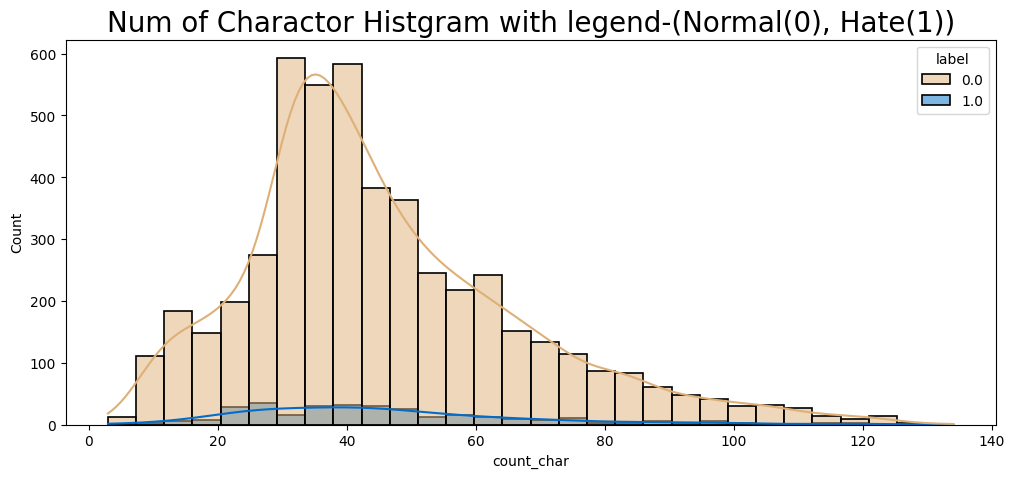

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.histplot(
    x="count_char", hue=label_name, data=df.loc[:train.shape[0], :],
    linewidth=1.2, palette=pal[::-1], kde=True, fill=True, bins=30,
)
ax.set_title("Num of Charactor Histgram with legend-(Normal(0), Hate(1))", fontsize=20)

In [41]:
df.loc[df["count_char"].sort_values(ascending=False).head(10).index, :]

,id,source,text,label,clean_text,count_char
3836,a459d3a34,livejupiter,学歴別ガチャ引いて出てきた新卒に正社員養成プログラム受けさせるのが一番、採用教育コスト安く上...,0.0,学歴別ガチャ引いて出てきた新卒に正社員養成プログラム受けさせるのが一番採用教育コスト安く上が...,134
5479,123b58842,newsplus,中韓への謝罪はなかったけど日本がハルノートを受け入れたんじゃない事を祈る\nイギリスみたいな...,NaN,中韓への謝罪はなかったけど日本がハルノートを受け入れたんじゃない事を祈るイギリスみたいな二枚...,133
8162,e64d4b467,newsplus,偏狭なイスラム原理主義に対する抗議の姿勢というなら、何も信仰の対象を貶める風刺画を大衆紙面表...,NaN,偏狭なイスラム原理主義に対する抗議の姿勢というなら何も信仰の対象を貶める風刺画を大衆紙面表紙...,131
1627,1216a9092,newsplus,個人的には、もっと細かいレベルのインシデントまでひたすら公開しつつインシデントのレベルについ...,0.0,個人的にはもっと細かいレベルのインシデントまでひたすら公開しつつインシデントのレベルについて...,129
8292,efaa43ef6,livejupiter,調べてきたんやがフェミニズムって「性差別を廃止し、抑圧されていた女性の権利を拡張しようとする...,NaN,調べてきたんやがフェミニズムって性差別を廃止し抑圧されていた女性の権利を拡張しようとする思想...,129
6452,5f2074aee,livejupiter,いわゆる日常系のファンタジーものやけど、世界観やキャラなんかの作り込みが奥深いからキャラたち...,NaN,いわゆる日常系のファンタジーものやけど世界観やキャラなんかの作り込みが奥深いからキャラたちが...,128
2319,fc5c47587,news4vip,お互いにお互いが言いたいことを素直に言える（いい方には配慮するが）ような関係がベストなんだよ...,0.0,お互いにお互いが言いたいことを素直に言える(いい方には配慮するが)ような関係がベストなんだよ...,128
5999,3ad662a09,newsplus,イスラムに差別的なキリスト国家のフランスが嫌ならイスラム諸国に帰れば良いんだよ。\n自分から...,NaN,イスラムに差別的なキリスト国家のフランスが嫌ならイスラム諸国に帰れば良いんだよ自分からキリス...,126
5035,296f45c72,newsplus,まぁ、時代を遡ればクジラもイルカも日本の食文化なんだろうが、今の時代本当に必要とされているか...,0.0,まぁ時代を遡ればクジラもイルカも日本の食文化なんだろうが今の時代本当に必要とされているかまた...,125
2836,ff1d7c0ba,livejupiter,これはガイジ\nコーカソイドが肌白いのは日射時間の短い寒冷地でビタミンDを作るために効率良く...,0.0,これはガイジコーカソイドが肌白いのは日射時間の短い寒冷地でビタミンDを作るために効率良く日光...,125


In [42]:
df.loc[3836, "clean_text"]

'学歴別ガチャ引いて出てきた新卒に正社員養成プログラム受けさせるのが一番採用教育コスト安く上がるしそこで引っかからんで派遣やっとる人の中にも優秀な人はおるかもしれんけど確率的に低いのは確かやしな採用側からしたらなんで新卒カード持っとる時に正社員ならんかったん?ってなるわ'